# STA 208: Homework 4(Do not distribute)

## Due Monday 6/2/2019 at midnight

__Instructions:__ Submit it on canvas.  The canvas should include all of your code either in this notebook file, or a separate python file that is imported and ran in this notebook.  We should be able to open this notebook and run everything here by running the cells in sequence.  The written portions can be either done in markdown and TeX in new cells or written clearly by hand when you hand it in.  Submit each file separately.

- Code should be well organized and documented
- All math should be clear and make sense sequentially
- When in doubt explain what is going on
- You will be graded on correctness of your math, code efficiency and succinctness, and conclusions and modelling decisions

__Exercise 1__ (20 pts)

Recall that a Mercer kernel is a similarity function $k(x,x')$ such that the matrix $K_{ij} = ( k(x_i,x_j) )_{ij}$ is positive semidefinite regardless of dataset $\{x_i\}_{i=1}^n \subset \mathbb R^p$.


1. Suppose that $K = U \Lambda U^\top$ where $U$ is $n \times n$ and $\Lambda$ is diagonal.  What do we know about $\Lambda$ and why?

1. Let kernel ridge regression be the following minimization problem where $y \in \mathbb R^n$,
$$
\min_\beta \frac 12 \|y - \beta \|_2^2 + \beta^\top K \beta.
$$
Write the solution as a function of $\Lambda, U, y$.  What does this tell you about the effect of the eigenvalues on the solution (suppose that you only increase one of the eigenvalues).

1. Check if the following notions of similarity are Mercer kernels,
 1. $k(x,x') = x^\top x'$
 1. $k(x,x') = x_1 x'_1 - x_2 x_2', \quad x, x' \in \mathbb R^2$ 
 1. $k(s,s') = 1\{s,s' \textrm{ have the same sentence structure}\}$ where the sentence structure is the sequence of parts-of-speech for each word/phrase.  For example, "The cat ran around the house." is "noun verb preposition noun" has the same structure as "Steve forgot about the homework".

__Exercise 2__ (40 pts)

Load the poses.csv dataset, which is a concatenation of other datasets to form a larger dataset.  I want you to act like the dataset is from the same experiment. 

1. Apply 1 time lag difference of the dataset, so that each variable is the difference of the time point and the previous time point.  Standardize the dataset and remove any variables that do not make sense.  Run the PCA decomposition with 2 principal components.  Plot the 2 principal components.  Which variables have the most loading on the principal components (look at `.components_`)?

1. Also on the 1 lagged dataset.  Run K-means clustering (with 6 clusters), how much does the cluster overlap with the 'task' variable.  Look at the confusion matrix of the cluster against the 'task'.  Is there a clear mapping from clusters to task?

1. Standardize the data and train an HMM with an appropriately chosen emission distribution.  How much does the hidden state overlap with the 'task' variable?  

In [4]:
import numpy as np
import re
import pandas as pd



Some lines in the data was in wrong format and the below two blocks should be able to fix that problem. The idea is that each rwo has 8 numbers in total so we can extract the numbers with regular expression and then put them into the data frame.

In [5]:
lines = []
with open('poses.csv', "r") as input_file:
    lines = [line for line in input_file]#read the raw file in
lines = lines[1:]#delete the header line

data_numbers = [re.findall(r'\b[0-9]+\.?[0-9]*\b', line) for line in lines]#extract all numbers in a line
def get_numbers(list_of_strings):
    return [float(a) for a in list_of_strings]#string to float
data_numbers = [get_numbers(line) for line in data_numbers]#create a list of numbers

poses = pd.read_csv('poses.csv', dtype=str)#read in all columns as strings
data_matrix = np.array(data_numbers)
poses.iloc[:,:8] = data_matrix#import correct data

poses.head()



,Unnamed: 0,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,task,filename
0,0,0,42,0,11.5,4.56,18.5,0.87,sitting,dataset14.csv
1,1,250,41.75,0.43,21.5,1.8,11.75,1.48,sitting,dataset14.csv
2,2,500,41.67,0.47,9.33,5.44,12,2.83,sitting,dataset14.csv
3,3,750,40,0.82,12.67,0.94,17.75,1.09,sitting,dataset14.csv
4,4,1000,40.25,0.83,12.25,0.43,18.25,0.43,sitting,dataset14.csv


In [6]:
#Here I only want to select columns easier in the future, you can igonre this block.
col_names = poses.columns.values
poses.rename(columns={col_names[0]:'Id', col_names[1]:'Time'}, inplace=True)
poses.head()



,Id,Time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,task,filename
0,0,0,42,0,11.5,4.56,18.5,0.87,sitting,dataset14.csv
1,1,250,41.75,0.43,21.5,1.8,11.75,1.48,sitting,dataset14.csv
2,2,500,41.67,0.47,9.33,5.44,12,2.83,sitting,dataset14.csv
3,3,750,40,0.82,12.67,0.94,17.75,1.09,sitting,dataset14.csv
4,4,1000,40.25,0.83,12.25,0.43,18.25,0.43,sitting,dataset14.csv


Besides, we also noticed that there are seven tasks in the dataset, including 'bending1' and 'bending2'. Here we replace both with 'bending' so we would have 6 tasks in total, which equals to the number of clusters in K-means.

In [7]:
poses.task = poses.task.replace(to_replace=['bending1','bending2'], value='bending')
poseslist = poses.task.unique()



In [8]:
poses.describe() #to see if there is missing data



,Id,Time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,task,filename
count,42239.0,42239.0,42239.0,42239.0,42239.0,42239.0,42239.0,42239.0,42239,42239
unique,480.0,480.0,354.0,689.0,304.0,488.0,363.0,522.0,6,15
top,239.0,32750.0,45.0,0.0,12.0,0.0,18.0,0.0,standing,dataset3.csv
freq,88.0,88.0,2969.0,10541.0,1942.0,8387.0,1189.0,4935.0,7200,3360


Drop the unnecessary columns.

In [9]:
poseslag=poses.drop(['Id','filename'], axis=1)
poseslagCopy = poseslag.copy()
poseslag = poseslag.drop(['task'], axis=1)
poseslag.head()



,Time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,42,0,11.5,4.56,18.5,0.87
1,250,41.75,0.43,21.5,1.8,11.75,1.48
2,500,41.67,0.47,9.33,5.44,12,2.83
3,750,40,0.82,12.67,0.94,17.75,1.09
4,1000,40.25,0.83,12.25,0.43,18.25,0.43


In [11]:
from sklearn import preprocessing
Time = poseslag['Time'].values
print(Time)
zeroIndex = np.array(np.where(Time==0.0)).flatten()
print(zeroIndex)

print('shape of the frame: ',poseslag.iloc[:,:].shape)
#Let's standedize the variables before taking the difference - standerdicing after the lag gave worse results
stand = preprocessing.StandardScaler()
stand.fit(poseslag.iloc[:,1:7])

poseslag.iloc[:,1:7] = stand.transform(poseslag.iloc[:,1:7])



[0.0 250.0 500.0 ... 119250.0 119500.0 119750.0]
[    0   480   960  1440  1919  2399  2879  3359  3839  4319  4799  5279
  5759  6239  6719  7199  7679  8159  8639  9119  9599 10079 10559 11039
 11519 11999 12479 12959 13439 13919 14399 14879 15359 15839 16319 16799
 17279 17759 18239 18719 19199 19679 20159 20639 21119 21599 22079 22559
 23039 23519 23999 24479 24959 25439 25919 26399 26879 27359 27839 28319
 28799 29279 29759 30239 30719 31199 31679 32159 32639 33119 33599 34079
 34559 35039 35519 35999 36479 36959 37439 37919 38399 38879 39359 39839
 40319 40799 41279 41759]
shape of the frame:  (42239, 7)


Let's look at the standerdized data

In [12]:
poseslag.head()


,Time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,0.48645,-0.712491,-0.511122,1.86506,0.365922,-0.458571
1,250,0.447001,-0.502525,1.32866,0.181616,-0.636165,-0.08595
2,500,0.434377,-0.482993,-0.910355,2.40181,-0.599051,0.738704
3,750,0.170854,-0.31209,-0.295867,-0.342934,0.254579,-0.324183
4,1000,0.210303,-0.307207,-0.373138,-0.654005,0.328808,-0.727347


In [13]:
for i in range(1,zeroIndex.shape[0]):
    dfTemp = poseslag.iloc[zeroIndex[i-1]:zeroIndex[i],:]# select the cts time frame
    dfTemp = dfTemp.diff()#1-lag difference
    #print(dfTemp)
    poseslag.iloc[zeroIndex[i-1]:zeroIndex[i],:] = dfTemp #replace with differences
    
#last timeframe    
dfTemp = poseslag.iloc[zeroIndex[-1]:Time.shape[0],:]# select the cts time frame
dfTemp = dfTemp.diff()#1-lag difference
poseslag.iloc[zeroIndex[-1]:Time.shape[0],:] = dfTemp #replace with differences 

#Now drop NA rowa
poseslag = poseslag.dropna()
poseslag.head()

poseslag = poseslag.drop(['Time'],axis=1)
poseslag.head()



,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
1,-0.0394496,0.209966,1.83978,-1.68344,-1.00209,0.372621
2,-0.0126239,0.0195317,-2.23902,2.22019,0.0371143,0.824654
3,-0.263523,0.170903,0.614488,-2.74474,0.85363,-1.06289
4,0.0394496,0.00488293,-0.077271,-0.311071,0.0742287,-0.403164
5,0.0394496,-0.161137,-0.0919892,0,-0.222686,0.244342


Contruct X and y variables

In [14]:
y = poses.drop(zeroIndex)[['task']].values
X = poseslag.values

X.shape, y.shape



((42151, 6), (42151, 1))

Now we are done with data preparation.

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.decomposition import PCA



In [16]:
#normaliza X
#standerdize x values
#stand = preprocessing.StandardScaler()
#stand.fit(X)
Xnew = X#stand.transform(X)
print(Xnew)
#PCA
pca_poses=PCA(2,whiten=False)
X_proj = pca_poses.fit_transform(Xnew)
X_proj.shape



[[-0.03944956609486683 0.20996618889278673 1.8397846631271664
  -1.683440621753161 -1.0020870473087864 0.3726213395681395]
 [-0.01262386115035713 0.019531738501654572 -2.2390179350257617
  2.2201898055005462 0.03711433508551054 0.8246537842901448]
 [-0.2635231015137106 0.17090271188947764 0.6144880774844736
  -2.7447401441627632 0.8536297069667441 -1.0628870997517421]
 ...
 [0.03944956609486683 -0.1611368426386503 0.1379838497345375
  1.1710891281761122 0.0 0.22601622236100255]
 [0.03944956609486683 -0.03418054237789553 0.5059407823599708
  -0.26227516933110856 -0.14845734034204217 -0.22601622236100255]
 [-0.07889913218973366 0.19531738501654583 0.9198923315635834
  -0.9088139588450037 -0.07422867017102108 0.1282794775562447]]


(42151, 2)

plot the 2 PCA projections

In [17]:
import numpy as np
import matplotlib.pyplot as plt

['bending' 'cycling' 'lying' 'sitting' 'standing' 'walking']
[3 3 3 ... 0 0 0]


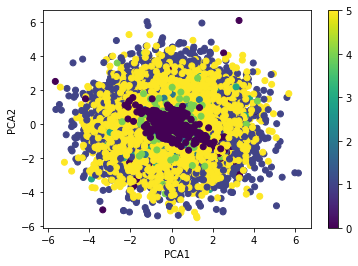

In [18]:
#convert y values to numbers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y.reshape((y.shape[0])))
ynew=le.transform(y.reshape((y.shape[0])))
print(le.inverse_transform([0,1,2,3,4,5]))
print(ynew)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.scatter(X_proj[:,0], X_proj[:,1], c=ynew)
plt.colorbar()
plt.show()
#following atr the labels for each number mapping.


calculate loadings

In [19]:
print(pca_poses.components_)
print(pca_poses.components_.shape)
print(pca_poses.explained_variance_ratio_)


[[-0.04163243  0.49197157 -0.18068327  0.73196364 -0.06540286  0.42841099]
 [ 0.00546743 -0.04225479  0.14011905 -0.4562811  -0.147734    0.86517831]]
(2, 6)
[0.29513513 0.26763138]


PCA-1 has the most loading from var_rss13 and PCA-2 has the most loading from var_rss23

2. K-means clustering - to map the out put labels to ground truths, I went through all the permutations of y label encoding and select the one with lowest hinge loss of the difference of labelling. This take time. I burrowed the labelling from HMM (next section which I ran completely and found to be the best.)

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	1.90s	1836093	0.367	0.404	0.384	0.284	0.384	0.262
random   	1.79s	1836094	0.367	0.405	0.385	0.285	0.385	0.264


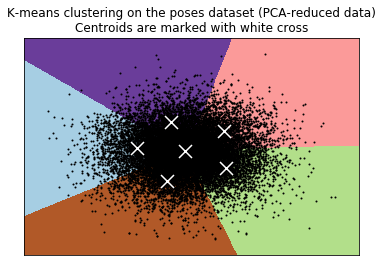

In [38]:
from sklearn.cluster import KMeans
from time import time
from sklearn import metrics
import itertools
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def createy(seq,y):
    yseq = np.zeros(y.shape)
    for i in range(0,y.shape[0]):
        yseq[i] = seq[list(poseslist.flatten()).index(y[i])]
        #print(yseq[i])
    return yseq

def genLabels(y_pred,y):
    print('in genLabels')
    minMSE = 500000
    minMapping = None
    perms=list(itertools.permutations([0, 1, 2,3,4,5]))
    for seq in perms:
        yseq = createy(seq,y).astype('int')
        MSE = np.sum(y_pred != yseq)
        if(minMSE>MSE):
            minMSE = MSE
            minMapping = yseq
    print('selected')
    return minMapping

def bench_k_means(estimator, name, data,labels):
    t0 = time()
    estimator.fit(data)
    #we need a function to map fitted labels to ground truths
    #ymap=genLabels(estimator.labels_,labels)
    #with the seq burrowed from next section,
    ymap = createy(minseq,y)
    ymap = ymap.astype('int')
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(ymap, estimator.labels_),
             metrics.completeness_score(ymap, estimator.labels_),
             metrics.v_measure_score(ymap, estimator.labels_),
             metrics.adjusted_rand_score(ymap, estimator.labels_),
             metrics.adjusted_mutual_info_score(ymap,  estimator.labels_,
                                                average_method='arithmetic'),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=300)))
    return estimator.labels_,ymap

y_pred,y_true = bench_k_means(KMeans(init='k-means++', n_clusters=6, n_init=10),
              name="k-means++", data=X,labels=ynew)

bench_k_means(KMeans(init='random', n_clusters=6, n_init=10),
              name="random", data=X,labels=ynew)

kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10)
kmeans.fit(X_proj)
reduced_data = X_proj
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the poses dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()




We can measure the overlapping of the clusters as mutual information, which is 0.385 for k-means. This means classes are not seperable and classes members are completely split across different clusters. hard to cluter.

Plot confusion matrix

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Normalized confusion matrix
[[6.58333333e-01 3.05555556e-03 2.09722222e-02 1.80138889e-01
  1.34027778e-01 3.47222222e-03]
 [4.58333333e-02 0.00000000e+00 2.11111111e-01 7.41805556e-01
  2.77777778e-04 9.72222222e-04]
 [5.08012821e-02 4.24679487e-01 1.60256410e-03 1.43750000e-01
  2.69070513e-01 1.10096154e-01]
 [1.15432699e-01 9.30684817e-03 1.95443812e-01 6.10084734e-01
  6.69537436e-02 2.77816363e-03]
 [6.59722222e-01 0.00000000e+00 1.09722222e-02 4.97222222e-02
  2.61527778e-01 1.80555556e-02]
 [1.52777778e-03 0.00000000e+00 7.17777778e-01 6.72222222e-02
  6.66666667e-03 2.06805556e-01]]


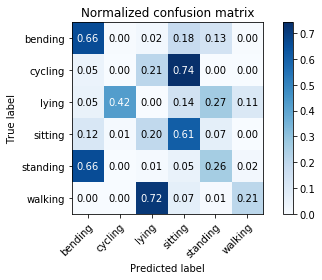

In [40]:
#plot confution mat
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=le.inverse_transform([0, 1, 2,3,4,5]), normalize=True,
                      title='Normalized confusion matrix')




This is because the classes are not seperable.

HMM

In [26]:
poseslagCopy = poseslagCopy.drop(['Time'],axis=1)
y = poseslagCopy['task'].values
X = poseslagCopy.drop(['task'],axis=1).values

X.shape, y.shape



((42239, 6), (42239,))

In [27]:
#standerdize x values
stand = preprocessing.StandardScaler()
stand.fit(X)
Xnew2 = X#stand.transform(X)
from hmmlearn import hmm
model= hmm.GaussianHMM(n_components=6).fit(Xnew2)
y_pred=model.predict(Xnew2)
print(y_pred)



[0 4 4 ... 2 2 2]


In [34]:
#create labels for 
import statistics 
from statistics import mode 
from sklearn.metrics import mean_squared_error,log_loss
import itertools


def createy(seq):
    yseq = np.zeros(y.shape)
    for i in range(0,y.shape[0]):
        yseq[i] = seq[list(poseslist.flatten()).index(y[i])]
        #print(yseq[i])
    return yseq

minMSE = 500000
minMapping = None
minseq = None
perms=list(itertools.permutations([0, 1, 2,3,4,5]))
for seq in perms:
    yseq = createy(seq).astype('int')
    MSE = np.sum(y_pred != yseq)
    if(minMSE>MSE):
        minMSE = MSE
        minMapping = yseq
        minseq = seq
    
print('hinge loss of the classification of Gaussian HMM',minMSE)




hinge loss of the classification of Gaussian HMM 22441


confusion matrix

Normalized confusion matrix
[[9.38750000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.12500000e-02 0.00000000e+00]
 [6.94444444e-04 7.74444444e-01 0.00000000e+00 6.94444444e-04
  1.31944444e-02 2.10972222e-01]
 [4.96794872e-03 8.81410256e-03 4.12339744e-01 1.31250000e-01
  6.82692308e-02 3.74358974e-01]
 [2.77777778e-04 2.00555556e-01 0.00000000e+00 6.95972222e-01
  9.55555556e-02 7.63888889e-03]
 [5.70694444e-01 4.16666667e-04 0.00000000e+00 5.55555556e-04
  4.28333333e-01 0.00000000e+00]
 [1.80580636e-03 2.11418253e-01 3.47270454e-03 5.36602306e-01
  1.31407140e-01 1.15293791e-01]]


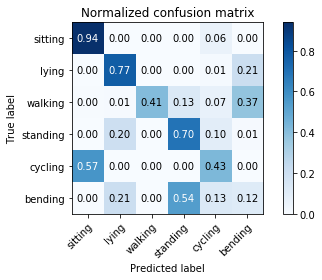

In [31]:
plot_confusion_matrix(minMapping.astype('int'), y_pred, classes=poseslist.flatten(), normalize=True,
                      title='Normalized confusion matrix')




This is better than the previous case. Let's calculate the mutual info for the classses to calculate the overlapping.

In [32]:
print(metrics.adjusted_mutual_info_score(minMapping.astype('int'), y_pred,average_method='arithmetic'))




0.5195375070333829


classes members are less split across different clusters which is favourable.

__Exercise 3__ (40 pts)


Load the housing.csv dataset, your task is to predict the Sale price.  Deal with the missing data by simple imputation and by creating missingness indicator variables.  Train random forests, gradient tree boosting (XGBoost), K-nearest neighbors, and kernel SVMs.  Compare them using appropriate cross-validation.

In [23]:
#read the data frames
data_mat = pd.read_csv('housing.csv')
data_mat.head()



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [24]:
data_mat.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [25]:
#create a missing variables: 
#first drop id and sales price
data_matforfill = data_mat.drop(['Id','SalePrice'],axis=1)
data_matforfill.describe()

#create missingdataframe
data_null = data_matforfill.isnull()
data_null.head()

#change column names
for i in data_null.columns.values:
    data_null.rename(columns={i:i+'m'}, inplace=True)
    
data_null = data_null.astype('int')
data_null.head()

,MSSubClassm,MSZoningm,LotFrontagem,LotAream,Streetm,Alleym,LotShapem,LandContourm,Utilitiesm,LotConfigm,...,ScreenPorchm,PoolAream,PoolQCm,Fencem,MiscFeaturem,MiscValm,MoSoldm,YrSoldm,SaleTypem,SaleConditionm
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0


create one hot encoding for categorical variables

In [26]:
#imputate nan values.
data_mat = data_mat.fillna(data_mat.mode().iloc[0])

#select cat columns
cat_columns = data_mat.select_dtypes(['object']).columns
#print('cat columns',cat_columns)
dataCat = data_mat.filter(cat_columns)
dataCat.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
1,RL,Pave,Grvl,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
2,RL,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
3,RL,Pave,Grvl,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Abnorml
4,RL,Pave,Grvl,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal


In [27]:
#one hot encoding for each column
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(dataCat)
Onehotarray=enc.transform(dataCat).toarray()

form X and y

In [34]:
datanum=data_mat.drop(cat_columns,axis=1)
#concat missing values
datanum = pd.concat([datanum, data_null], axis=1)
datanum.head()
X = datanum.drop(['Id','SalePrice'],axis=1).values
y = datanum['SalePrice'].values
#print('shapes',X.shape,y.shape)

#concatenate one hot matrix
X = np.concatenate((X,Onehotarray),axis=1)
#print('shapes',X.shape,y.shape)
X = X.astype('float32')
y = y.astype('float32')
#center y
y = y-np.mean(y)
X.shape, y.shape

((1460, 367), (1460,))

K-fold cross validation with K=5

In [38]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize,StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model,svm
from matplotlib import pyplot as plt

split the dataset

In [39]:
#standerdise X
stand = StandardScaler()
X_new = stand.fit_transform(X)

X_tr, X_te, y_tr, y_te = train_test_split(X_new,y,test_size=0.1,random_state=42)

In [40]:
kf = KFold(n_splits=5, shuffle=True, random_state=17)#Fix the results
kf.get_n_splits(X_tr)
train_indices = []
test_indices = []
for train_index, test_index in kf.split(X_tr):
    train_indices.append(train_index)
    test_indices.append(test_index)

train a linear regression as a benchmark

In [43]:
LRlosses=[]
for k in range(5):
    lm = linear_model.LinearRegression(fit_intercept=False)
    lm.fit(X_tr[train_indices[k]], y_tr[train_indices[k]])
    y_pred = lm.predict(X_tr[test_indices[k]])
    LRlosses.append(mean_squared_error(y_tr[test_indices[k]],y_pred))
print('CV loss of linear regression:', np.sqrt(np.mean(LRlosses)))

CV loss of linear regression: 141667860.0


Train a random forest

0
1
2
3
4
CV loss of random forests: [31133.89492345 31034.48469363 31066.5773047  31037.56611726
 31043.25479958]
CV loss of Xgboost: [31133.89492345 31034.48469363 31066.5773047  31037.56611726
 31043.25479958]


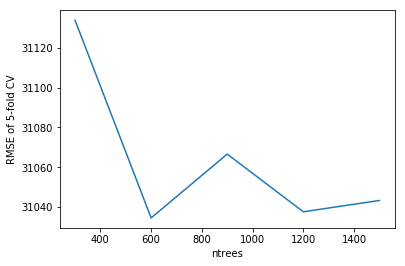

In [45]:
from sklearn.ensemble import RandomForestRegressor
RFlosses= np.zeros((5,5))
# Instantiate model with 1000 decision trees
for i in range(5):
    print(i)
    for k in range(5):
        rf = RandomForestRegressor(n_estimators = i*300 +300, random_state = 42)
        rf.fit(X_tr[train_indices[k]], y_tr[train_indices[k]])
        y_pred = rf.predict(X_tr[test_indices[k]])
        RFlosses[i,k] = mean_squared_error(y_tr[test_indices[k]],y_pred)**0.5
print('CV loss of random forests:', np.mean(RFlosses,axis=1))
print('CV loss of Xgboost:', np.mean(RFlosses,axis=1))
plt.plot(range(300, 1800,300), np.mean(RFlosses, axis=1))
plt.xlabel('ntrees')
plt.ylabel('RMSE of 5-fold CV')
plt.show()

CV loss for the tandom forest is RMSE = 31034 $ at 600 trees 

Train Xgboost

0
1
2
3
4
CV loss of Xgboost: [29569.42009421 29521.33423718 29553.81701349 29591.00520153
 29602.85134813]


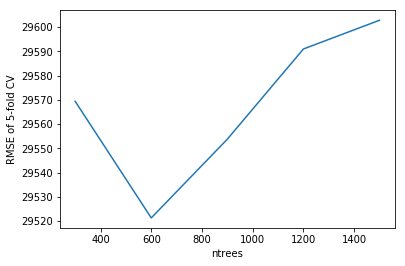

In [46]:
XGBlosses = np.zeros((5,5))
import xgboost as xgb
for i in range(5):
    print(i)
    for k in range(5):
        xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 3, alpha = 10, n_estimators = i*300+300)
        xg_reg.fit(X_tr[train_indices[k]], y_tr[train_indices[k]])
        y_pred = xg_reg.predict(X_tr[test_indices[k]])
        XGBlosses[i,k] = mean_squared_error(y_tr[test_indices[k]],y_pred)**0.5
print('CV loss of Xgboost:', np.mean(XGBlosses,axis=1))
plt.plot(range(300, 1800,300), np.mean(XGBlosses, axis=1))
plt.xlabel('ntrees')
plt.ylabel('RMSE of 5-fold CV')
plt.show()

CV error for Xgboost is RMSE = 29521$ at 600 trees

Train K nearest neighbors

CV loss of KNNlosses: [50727.82510177 45440.87280858 43285.10672824 42608.41535175
 42069.47429465 41396.79390145 41402.57623926 41265.68664991
 41242.33564043 41222.77327505 40977.51906625 41113.65516264
 41137.79483345 41342.97866879 41399.87067262 41419.95426065
 41467.52606592 41774.68710704 41738.47898334 41844.96686238]


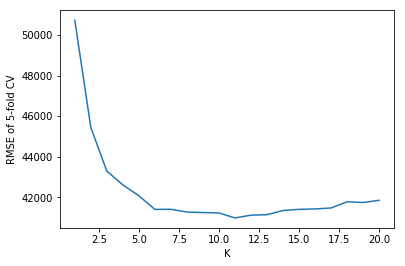

In [47]:
KNNlosses = np.zeros((5,20))
for k in range(20):
    regressor = KNeighborsRegressor(n_neighbors = k*1+1)
    for index in range(5):
        regressor.fit(X_tr[train_indices[index]], y_tr[train_indices[index]])
        predictions = regressor.predict(X_tr[test_indices[index]])
        KNNlosses[index, k] = mean_squared_error(predictions, y_tr[test_indices[index]])**0.5
print('CV loss of KNNlosses:', np.mean(KNNlosses,axis=0))
plt.plot(range(1,21), np.mean(KNNlosses, axis=0))
plt.xlabel('K')
plt.ylabel('RMSE of 5-fold CV')
plt.show()

CV error for KNN is RMSE = 40978$ at 11 neighbors

Train KernelSVD

0
1
2
3
4
5
6
7
8
9
CV loss of Linear SVM: [15221.52471191 14684.66574958 14796.08072802 14879.27878785
 15242.34083338 15021.13814618 14862.98352764 15073.5285543
 15484.71847919 15617.03649246]


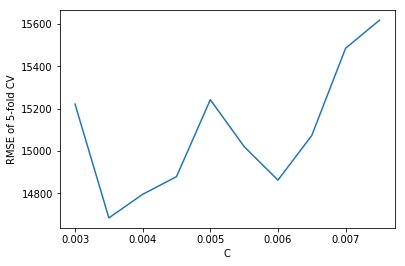

In [49]:
#Linear
SVMlossesl = np.zeros((5,10))
for k in range(10):
    print(k)
    svm_sim = svm.SVC(kernel="linear",C=k*0.0005+0.003,gamma='auto')
    for index in range(5):
        svm_sim.fit(X_tr[train_indices[index]], y_tr[train_indices[index]].astype('int'))
        predictions = svm_sim.predict(X_tr[test_indices[index]])
        SVMlossesl[index, k] = mean_squared_error(predictions, y_tr[test_indices[index]].astype('int'))**0.5
print('CV loss of Linear SVM:', np.mean(SVMlossesl,axis=0))
plt.plot(np.arange(10).astype('float32')*0.0005+0.003, np.mean(SVMlossesl, axis=0))
plt.xlabel('C')
plt.ylabel('RMSE of 5-fold CV')
plt.show()

0
1
2
3
4
5
6
7
8
9
CV loss of RBF SVM: [13673.68050744 13673.68050744 13673.68050744 13673.68050744
 13673.68050744 13676.05285401 13707.22115734 14466.7886209
 14663.89351318 14700.88343676]


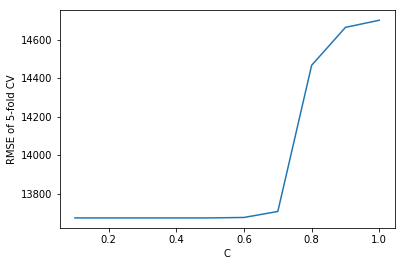

In [50]:
#rbf - not sensitive to c after 0.6
SVMlossesr = np.zeros((5,10))
for k in range(10):
    print(k)
    svm_sim = svm.SVC(kernel="rbf",C=k*0.1+0.1,gamma='auto')
    for index in range(5):
        svm_sim.fit(X_tr[train_indices[index]], y_tr[train_indices[index]].astype('int'))
        predictions = svm_sim.predict(X_tr[test_indices[index]])
        SVMlossesr[index, k] = mean_squared_error(predictions, y_tr[test_indices[index]].astype('int'))**0.5
print('CV loss of RBF SVM:', np.mean(SVMlossesr,axis=0))
plt.plot(np.arange(10)*0.1+0.1, np.mean(SVMlossesr, axis=0))
plt.xlabel('C')
plt.ylabel('RMSE of 5-fold CV')
plt.show()

0
1
2
3
4
CV loss of RBF SVM: [13716.98355805 14036.66720102 13596.16840847 14036.66720102
 14037.11511149]


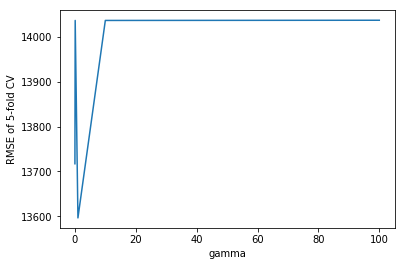

In [56]:
#rbf - tuning for when c= 0.4
SVMlossesrg = np.zeros((5,5))
gamma = np.array([1e-2,1e-1,1,10,100]).astype('float32')
for k in range(5):
    print(k)
    svm_sim = svm.SVC(kernel="rbf",C=0.4,gamma=gamma[k])
    for index in range(5):
        svm_sim.fit(X_tr[train_indices[index]], y_tr[train_indices[index]].astype('int'))
        predictions = svm_sim.predict(X_tr[test_indices[index]])
        SVMlossesrg[index, k] = mean_squared_error(predictions, y_tr[test_indices[index]].astype('int'))**0.5
print('CV loss of RBF SVM:', np.mean(SVMlossesrg,axis=0))
plt.plot(gamma, np.mean(SVMlossesrg, axis=0))
plt.xlabel('gamma')
plt.ylabel('RMSE of 5-fold CV')
plt.show()

RBF kernels perform better than linear kenels for the following tuned values.

Summary of the results
I obtained the following results.

| Method | 5 - fold CV RMSE | parameter |
| --- | --- | --- |
| Linear regression | 141667860.0 | with intercept |
| Random forest | 31034 | ntrees = 900 |
| Xgboost | 29521 | ntrees = 900 |
| KNN | 40977| K = 11| |
| SVM - Linear | 14684 | C = 0.0035 |
| SVM - RBF | 13596 | C = 0.4 ,gamma = 1 |

RGF Kernel SVM performs the best. Let's calculate the test error for that.

In [57]:
svm_sim = svm.SVC(kernel="rbf",C=0.04,gamma=1)

svm_sim.fit(X_tr, y_tr.astype('int'))
predictions = svm_sim.predict(X_te)
print(mean_squared_error(predictions, y_te.astype('int'))**0.5)

15391.681400758845
